# Introductory applied machine learning (INFR10069)

# Assignment 2: Linear regression

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw1 05_Assignment_2.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=05_Assignment_2.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 05_Assignment_2.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Execute the cell below to import all packages you will be using in the rest of the assignemnt.

In [272]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

## Description of the dataset
This assignment is based on the automobile pricing dataset. Our goal will be to predict the price of automobiles based on various attributes. This data set consists of three types of entities: 

1. The specification of an automobile in terms of various characteristics 

1. Assigned insurance risk rating 
   * this rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuaries call this process ”symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. 

1. Normalized losses in use as compared to other cars
  * the third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year (avg_loss/car/year). 


To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We removed any instances that had one or more missing values and randomized the data set. The resulting representation is much more compact and can be used directly to perform our experiments.


## 1. Simple Linear Regression [50%]
We will begin by studying a simple Linear Regression model. Such a model will consider the relationship between a dependent (response) variable and only one independent (explanatory) variable. When applying machine learning in practice it can be prudent to start out simple in order to get a feeling for the dataset and for any potential difficulties that might warrant a more sophisticated model. In this Section we will consider one independent variable (i.e. feature) `engine-power` against the dependent variable (i.e. target) `price`.

### ========== Question 1.1 --- [1 mark] ==========
Load the dataset `train_auto_numeric.csv` into a pandas DataFrame called `auto_numeric`. Display the number of data points and attributes in the dataset.

In [273]:
# Load the datasets
data_path_auto_numeric = os.path.join(os.getcwd(), 'datasets', 'train_auto_numeric.csv')
auto_numeric = pd.read_csv(data_path_auto_numeric, delimiter = ',')
# Display info
print("Number of data points: {}".format(auto_numeric.shape[0]))
print("Number of attributes: {}".format(auto_numeric.shape[1]))

Number of data points: 159
Number of attributes: 16


### ========== Question 1.2 --- [1 mark] ==========
Display the first 8 instances of the dataset.

In [274]:
auto_numeric.head(8)

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
0,164.0,99.8,176.6,66.2,54.3,8.85,3.19,3.40,10.0,102000.0,5500.0,24.0,30.0,40.52,57.68,13950.0
1,110.0,99.4,162.4,66.4,54.3,15.18,3.19,3.40,8.0,115000.0,5500.0,18.0,22.0,47.39,59.59,17450.0
2,158.0,105.8,192.7,71.4,51.6,15.18,3.94,2.80,8.5,70000.0,4400.0,28.0,30.0,0.85,3344.79,17710.0
3,106.0,86.6,158.7,67.7,55.9,13.74,3.13,3.50,7.8,140000.0,5600.0,32.0,20.0,44.74,68.97,23875.0
4,192.0,101.2,176.8,64.8,54.3,8.67,3.50,2.80,8.8,101000.0,5800.0,23.0,29.0,44.78,53.48,16430.0
5,194.0,110.0,190.9,71.4,58.7,8.67,3.78,3.90,22.5,101000.0,6000.0,47.0,53.0,1.80,1330.28,16925.0
6,188.0,101.2,176.8,64.8,54.3,26.58,3.31,3.19,9.0,121000.0,4250.0,21.0,28.0,7.19,377.06,20970.0
7,150.0,101.2,176.8,64.8,56.1,26.58,3.03,3.19,8.0,134000.0,4400.0,28.0,37.0,57.37,48.20,21105.0


### ========== Question 1.3 --- [1 mark] ==========
Display the summary statistics for the dataset.

In [275]:
auto_numeric.describe()

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,121.955975,98.559748,171.698113,65.729560,53.925157,14.056352,3.294528,3.219874,10.446855,98528.301887,5072.012579,27.113208,32.327044,46.180503,200.055031,11684.723270
std,39.434186,5.803361,12.656791,2.292021,2.410446,17.143568,0.296959,0.381833,4.414796,34123.715967,549.988239,7.848229,8.231998,28.780966,513.289289,6744.910579
min,65.000000,86.600000,141.100000,60.300000,49.400000,3.390000,2.540000,2.070000,7.000000,48000.000000,4150.000000,15.000000,18.000000,0.490000,19.400000,5118.000000
25%,93.000000,94.500000,163.400000,64.000000,52.000000,6.960000,3.050000,3.070000,8.600000,69000.000000,4800.000000,22.000000,26.500000,21.775000,34.140000,7372.000000
50%,110.000000,97.000000,171.700000,65.400000,54.100000,9.030000,3.270000,3.270000,9.000000,92000.000000,5100.000000,26.000000,32.000000,49.800000,55.900000,9233.000000
75%,145.000000,101.200000,177.800000,66.500000,55.600000,14.885000,3.580000,3.410000,9.400000,116000.000000,5450.000000,31.000000,37.000000,68.495000,119.990000,14719.500000
max,256.000000,115.600000,202.600000,71.700000,59.800000,174.160000,3.940000,4.170000,23.000000,200000.000000,6600.000000,49.000000,54.000000,99.850000,3912.870000,42056.000000


### ========== Question 1.4 --- [2 marks] ==========
Produce a scatter plot of `price` against `engine-power`. Label axes appropriately and include a title in your plot.

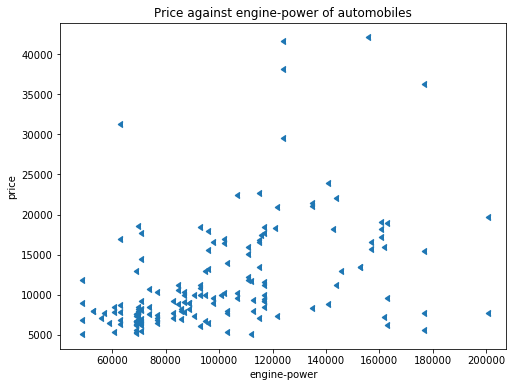

In [276]:
# Get the columns as arrays
price_array = np.asarray(auto_numeric['price'])
engine_array = np.asarray(auto_numeric['engine-power'])

# Show scatter plot
plt.figure(figsize = (8, 6))
plt.scatter(engine_array, price_array, marker = 4)
plt.xlabel('engine-power')
plt.ylabel('price')
plt.title('Price against engine-power of automobiles')
plt.show()

### ========== Question 1.5 --- [2 marks] ==========
Do you think that engine-power alone is sufficient for predicting the price? Can you make any other observations on the data from the above plot? Please explain your answer in 2-3 sentences. 

*Answer: *Looking at the data from the above plot, we can see that the data is quite spread out and that engine-power alone is not sufficient for predicting the price. The data shows that there can be various engine-power values with similar prices. Also, there are some outliers that do not give any useful information.

### ========== Question 1.6 --- [2 marks] ==========
Visualise the distribution of the car prices. Choose a sensible value for the number of bins in the histogram. Again, label axes appropriately and include a title in your plot.

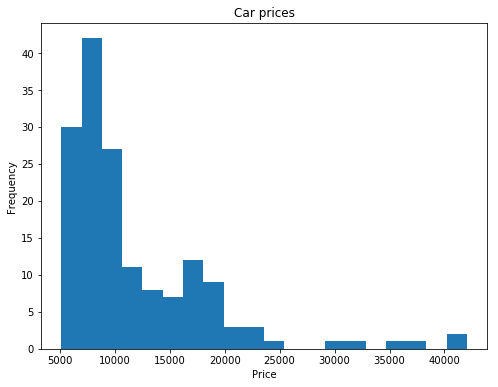

In [304]:
# Histogram for car prices distribution
plt.figure(figsize = (8,6))
plt.hist(price_array, bins = 20)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Car prices')
plt.show()

### ========== Question 1.7 --- [2 marks] ==========
How could you preprocess the data to improve the performance of linear regression? Don’t do it at this stage, but instead in one sentence explain why you would do what you suggested.

*Answer: *To improve the performance of linear regression, we could clean the data by removing the outliers.

### ========== Question 1.8 --- [1 mark] ==========
Now we want to build a simple linear regression model. First we need to define our input and target variables. Store the values of the attribute `engine-power` in a vector `X` and the values of our target variable `price` in a vector `y`.

In [278]:
# Define input and target variable
X = auto_numeric['engine-power']
y = auto_numeric['price']

### ========== Question 1.9 --- [1 mark] ==========
For technical reasons, we need to convert `X` into a 2D array, otherwise we will receive an error when trying to use it for building models. Perform this transformation and confirm that the shape of the resulting array is (`n`,1) where `n` is the number of instances in the dataset. 

In [279]:
X_2D = np.reshape(X, (-1,1))
X_2D.shape

(159, 1)

### ========== Question 1.10 --- [1 mark] ==========
Now we want to use Hold-out validation to split the dataset into training and testing subsets. Use 80% of the data for training and the remaining 20% for testing. Store your data into matrices `X_train`, `X_test`, `y_train`, `y_test`.

In [280]:
# Use imported method
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, train_size = 0.8, test_size = 0.2)

### ========== Question 1.11 --- [2 marks] ==========
By using Scikit-learn's [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fit a model to the training data. When initialising the model, set the `normalize` parameter to `True` and use default settings for the other parameters.

In [281]:
# Initialise the model and fit the training data
LR = LinearRegression(normalize = True)
LR.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### ========== Question 1.12 --- [2 marks] ==========
By looking into the attributes of your model, write down an equation for predicting the price of a car given the engine-power.

In [282]:
# y = mx + c
m = LR.coef_[0]
c = LR.intercept_
line = m*X_train + c

print("y = {}x + {}".format(m, c))

y = 0.096435128434x + 2369.61065409


### ========== Question 1.13 --- [3 marks] ==========
What happens to the price as one more unit of engine-power is added? By examining the magnitude of the regression coefficient is it possible to tell whether or not engine-power is an important influential variable on price? Explain your answer in 1-2 sentences.

*Answer: *One more unit of engine-power could affect the price, as the line of regression could move slightly. The regression coefficient can indicate whether a variable can influence another. A regression coefficient greater than zero, i.e. the slope is not flat, suggests that changes in price are associated with changes in engine-power.


### ========== Question 1.14 --- [2 marks] ==========
Produce a scatter plot similar to the one in Question 1.4 but use training data only this time. Add the regression line to the plot and show the predictions on the training set by using a different marker. Label axes appropriately and add a title to the graph. 

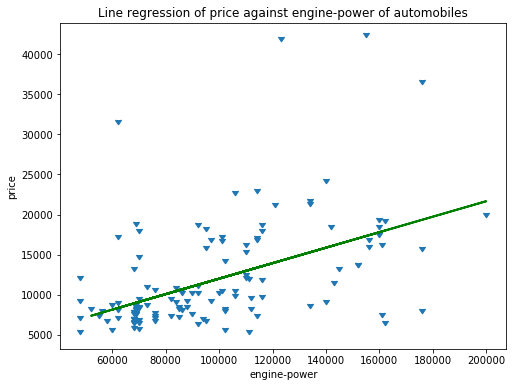

In [283]:
# Make predictions using the testing set
auto_numeric_pred = LR.predict(X_test)

# Show scatter plot and regression line
plt.figure(figsize = (8, 6))
plt.scatter(X_train, y_train, marker = 7)
plt.plot(X_test, auto_numeric_pred, color = 'g', linewidth = 2)
plt.xlabel('engine-power')
plt.ylabel('price')
plt.title('Line regression of price against engine-power of automobiles')
plt.show()

### ========== Question 1.15 --- [2 marks] ==========
So far we have used Hold-out validation. Can you think of a disadvantage of using this method, especially when dealing with small datasets?

*Answer: *Splitting a small dataset randomly to training and test sets sometimes can be bad, because with a small dataset you might take some data for testing that you have never used before for training, thus the model will fail for that data.

### ========== Question 1.16 --- [1 mark] ==========
Now we want to use k-fold cross-validation to evaluate the performance of the regression model. Famliriase yourself with the sklearn method [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and make sure you understand the differences between Hold-out and K-fold cross-validation. By using Scikit-learn's [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class construct a 5-fold cross-validation object. Set the `shuffle` parameter to `True` and `random_state` to `0`. Use the object to print the training and validation indices for the `auto_numeric` dataset (hint: see the `split` method).

In [284]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

### ========== Question 1.17 --- [3 marks] ==========
By making use of the iterator you constructed in the previous question, loop through the 5 folds and display the mean value of the `price` variable for the training instances in each fold.

In [285]:
# Show mean values
k = 1
for train_index, test_index in k_fold.split(auto_numeric):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Fold {} Mean: {}".format(k, np.mean(y_train)))
    k += 1

Fold 1 Mean: 11853.2677165
Fold 2 Mean: 11635.976378
Fold 3 Mean: 11689.8740157
Fold 4 Mean: 11709.8267717
Fold 5 Mean: 11535.84375


### ========== Question 1.18 --- [3 marks] ==========
Now initialise a new `LinearRegression` model and fit it by making use of the cross-validation iterator, the `X` and `y` arrays defined above and the [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function. Display the shape of your prediction and confirm it has the same dimensionality as your `y` vector.

In [286]:
# New Model
LR_cross = LinearRegression(normalize = True)
cross_pred = cross_val_predict(LR_cross, X_2D, y, cv = k_fold.split(X))
    
print("Prediction's dimensionality: {}, y vector's dimensionality: {}".format(cross_pred.shape, y.shape))

Prediction's dimensionality: (159,), y vector's dimensionality: (159,)


### ========== Question 1.19 --- [2 marks] ==========
Report the Coefficient of Determination (R^2), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC) from the simple linear regression model you build in Question 1.18. *Hint: RMSE is the square root of the Mean Squared Error (MSE). For CC you might find numpy's [`corrcoef`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) function useful.* 

In [287]:
def show_metrics(predicted, original):
    # Correlation Coefficient
    cc = np.corrcoef(predicted, original)[0,1]
    print("Correlation Coefficient: ", cc)
    # Coefficient of Determination
    print("Coefficient of Determination: ", r2_score(original, predicted))
    # Root Mean Squared Error
    mse = mean_squared_error(original, predicted, multioutput = 'raw_values')
    rmse = np.sqrt(mse)
    print('Root Mean Squared Error: ', rmse)
    # Mean Absolute Error
    mae = mean_absolute_error(original, predicted)
    print('Mean Absolute Error: ', mae)

In [288]:
show_metrics(cross_pred, y)

Correlation Coefficient:  0.417122199043
Coefficient of Determination:  0.173005270976
Root Mean Squared Error:  [ 6114.45211862]
Mean Absolute Error:  3987.95779619


### ========== Question 1.20 --- [4 marks] ==========
What do the above metrics intend to measure? Relate the values of CC, MAE and RMSE to the observations you made in Question 1.5. Explain your answer in 1-2 short paragraphs.

*Answer: *The low correlation coefficient(CC) suggests that indeed the engine-power cannot determine the price on its own, as the engine-power and price are correlated positevely but not with a high coeffiecient(0.417).<br>
The low coefficient of determination(R^2) suggests that the model does not improve the prediction over the mean model.<br>
The Root Mean Squared Error(RMSE) indicates the absolute fit of the model to the data. Normally lower values of RMSE indicate a better fit and a value of 6114 suggests that the model is doing fairly okay.<br>
The Mean Absolute Error(MAE) is the average of the absolute errors, which are the residuals of the model. Again, a lower value indicates a better fit and the value of 3988 suggests that the model is doing fairly okay.<br>

### ========== Question 1.21 --- [3 marks] ==========
Show a histogram of the residuals of the linear regression model (i.e. true - predicted values). Label axes appropriately and add a title to your plot. Does the distribution of residuals look like what you expected?

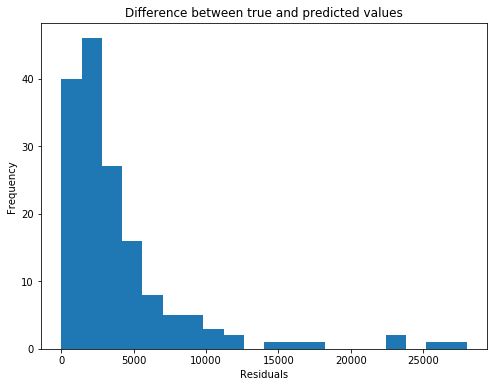

In [289]:
# Get the absolute values of the difference between true and predicted values
residuals = abs(y - cross_pred)
# Histogram for car prices distribution
plt.figure(figsize = (8,6))
plt.hist(residuals, bins = 20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Difference between true and predicted values')
plt.show()

*Answer: *Above I'm displaying the absolute value of the difference between the true and predicted values of the price. The distribution of the residuals looks like something I would expect, since the Mean Absolute Error we found in the previous question is 3988 and as we can see from the graph that most residuals are  ~4000.

### ========== Question 1.22 --- [2 marks] ==========
Load the new dataset `train_auto_base.csv` into a pandas DataFrame `auto_base`. Again by using the `engine-power` attribute as predictor and `price` as target variable build a LinearRegression model on this dataset. Report the R^2, RMSE, MAE and CC metrics for this model by making use of the K-fold CV iterator constructed in Question 1.16.

In [290]:
# Load the datasets
data_path_auto_base = os.path.join(os.getcwd(), 'datasets', 'train_auto_base.csv')
auto_base = pd.read_csv(data_path_auto_base, delimiter = ',')

# New Model
LR_base_cross = LinearRegression(normalize = True)
X_base = auto_base['engine-power']
y_base = auto_base['price']
X_2D_base = np.reshape(X_base, (-1,1))
# Use the 2D array for X as well as y vector from previous questions
base_cross_pred = cross_val_predict(LR_base_cross, X_2D_base, y_base, cv = k_fold.split(X_base))
print("Prediction's dimensionality: {}, y vector's dimensionality: {}".format(base_cross_pred.shape, y_base.shape))

# Show the metrics
show_metrics(base_cross_pred, y_base)

Prediction's dimensionality: (159,), y vector's dimensionality: (159,)
Correlation Coefficient:  -0.0619144160589
Coefficient of Determination:  -0.00213595381121
Root Mean Squared Error:  [ 6730.84360395]
Mean Absolute Error:  4901.86096203


### ========== Question 1.23 --- [2 marks] ==========
Show a scatter plot of predicted vs. true prices and another one of predicted price vs. engine-power. Use a single plot with two subplots. Label axes appropriately.

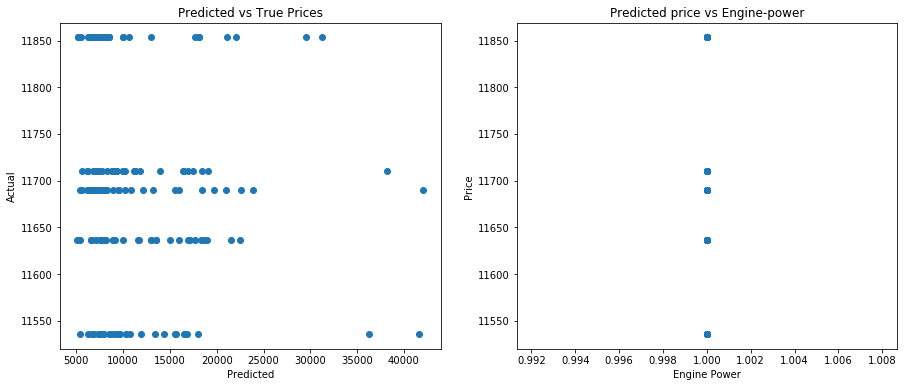

In [291]:
# First Scatter subplot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 6))
ax1.scatter(y_base, base_cross_pred)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Predicted vs True Prices')
# Second Scatter subplot
ax2.scatter(X_base, base_cross_pred)
ax2.set_xlabel('Engine Power')
ax2.set_ylabel('Price')
ax2.set_title('Predicted price vs Engine-power')
plt.show()

### ========== Question 1.24 --- [3 marks] ==========
What is the simplest baseline model for the purposes of regression? Relate your answer to the regression model you have just built as part of this question. Can the predictions of this model be justified given the procedure you followed to train it?

*Answer: *The simplest baseline model for the purposes of regression is taking the average value of the dependent variable. So, the average of the whole data for a variable will be the predicted value for the variable we want to predict.

### ========== Question 1.25 --- [2 marks] ==========
Why do you think this model performs so poorly? (*Hint: Justify your answer by displaying some statistics about the `auto_base` dataset.*)

In [292]:
auto_base.describe()

,engine-power,price
count,159.0,159.000000
mean,1.0,11684.723270
std,0.0,6744.910579
min,1.0,5118.000000
25%,1.0,7372.000000
50%,1.0,9233.000000
75%,1.0,14719.500000
max,1.0,42056.000000


As we can see from the engine-power data and the above statistics, all values are 1.0. That gives a mean value of 1.0 and if we are to use the baseline model proposed above, it will perform poorly.

## 2. Multivariate Linear Regression [50%]
In this Section we will fit a Multivariate Linear Regression model (LinearRegression) to the dataset. In contrast to Part 1, we will now train a model with multiple explanatory variables and ascertain how they affect our ability to predict the retail price of a car. One of our foremost concerns will be to determine exactly which attributes to include in the model and which may be left out.

### ========== Question 2.1 --- [10 marks] ==========
Use the original dataset (`auto_numeric`) and a visualisation tool of your choice to examine whether or not any of the other attributes are particularly good at predicting the price. Can you find any? Do any attributes appear useless at predicting the price? Do any attributes exhibit significant correlations? As you answer these questions, list two attributes for each question but do not modify the dataset at this stage. Of the attributes you listed, which ones could you safely remove? Explain in 4-5 sentences. *Hint: you might find seaborn's [`pairplot`](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function useful for this question.*

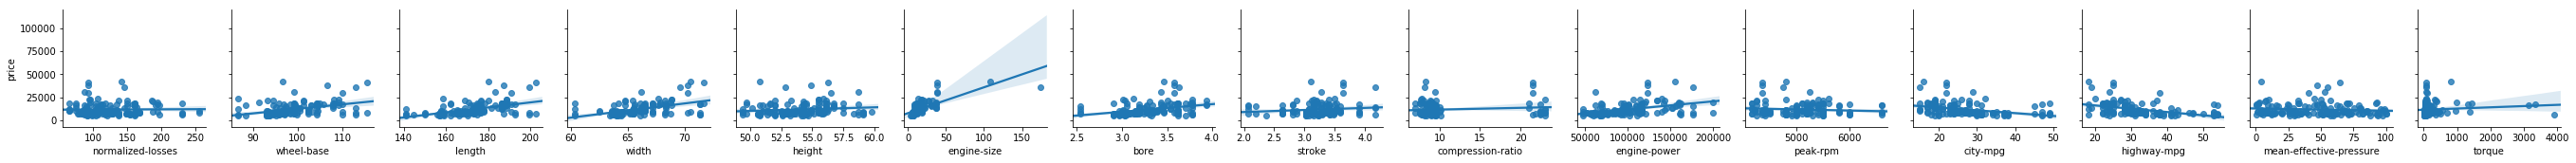

In [293]:
# Plot all variables against price
x_variables = auto_numeric.columns.values.tolist()
x_variables.remove('price')
sns.pairplot(auto_numeric, kind = "reg", x_vars=x_variables, y_vars=['price'])

*Answer: *Attributes that are particularly good at predicting the price and also show correlcation with the price are length and width, because we can see a slope indicating that as length and width increase, the price increases as well.<br>
Compression ratio and normalised-losses data are very spread out and the regression line is nearly flat, showing that there is no correlation between them and price. That means the price is nearly constant at various values.

### ========== Question 2.2 --- [3 marks] ==========
We will now make a first attempt at building a Multivariate Linear Regression model using all numeric attributes. Initialise a `LinearRegression` model and predict the output by using 5-fold cross-validation and the `cross_val_predict` function.

In [294]:
# Initialise a new Linear Regression model
MLR = LinearRegression(normalize = True)
X_whole = auto_numeric.drop(['price'], axis = 1)
# Use the 2D array for X as well as y vector from previous questions
mlr_cross_pred = cross_val_predict(MLR, X_whole, y, cv = k_fold.split(auto_numeric))
print("Prediction's dimensionality: {}, y vector's dimensionality: {}".format(mlr_cross_pred.shape, y.shape))

Prediction's dimensionality: (159,), y vector's dimensionality: (159,)


### ========== Question 2.3 --- [2 marks] ==========
Display the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC).

In [295]:
# Show the metrics asked
# Correlation Coefficient
cc_num = np.corrcoef(mlr_cross_pred, y)[0,1]
print("Correlation Coefficient: ", cc_num)
# Root Mean Squared Error
mse_num = mean_squared_error(y, mlr_cross_pred, multioutput = 'raw_values')
rmse_num = np.sqrt(mse_num)
print('Root Mean Squared Error: ', rmse_num)
# Mean Absolute Error
mae_num = mean_absolute_error(y, mlr_cross_pred)
print('Mean Absolute Error: ', mae_num)

Correlation Coefficient:  0.742560270537
Root Mean Squared Error:  [ 4819.80464283]
Mean Absolute Error:  3050.34459963


### ========== Question 2.4 --- [2 marks] ==========
 Comment on each metric display above in comparison to what you have obtained for the Simple Linear Regression model in Question 1.19.

*Answer: *Correlation coefficient is higher and RMSE and MAE are lower. All three metrics indicate that the Multivariate Linear Regression model performed better than the Simple Linear Regression model.

### ========== Question 2.5 --- [2 marks] ==========
Examine the histogram for the `engine-size` attribute. Choose a sensible value for the number of bins in the histogram. Label axes appropriately and include a title in your plot.

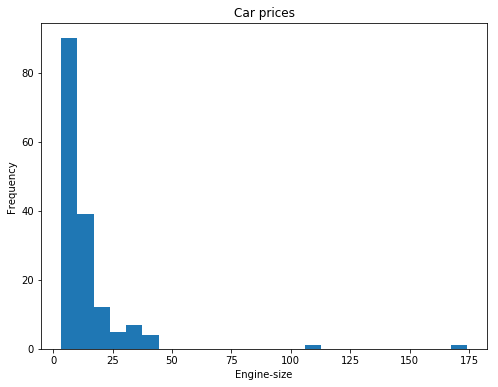

In [296]:
X_engine = auto_numeric['engine-size']
# Histogram
plt.figure(figsize = (8,6))
plt.hist(X_engine, bins = 25)
plt.xlabel('Engine-size')
plt.ylabel('Frequency')
plt.title('Car prices')
plt.show()

### ========== Question 2.6 --- [2 marks] ==========
Is the distribution expected to cause a problem for regression? Explain your answer in 2-3 sentences.

*Answer: *As we can see from the histogram, there is huge frequency in the 0-25 range of engine-size. That means there are not enough samples for other engine-sizes to make a good prediction for price. Also, there are some outliers in the data that will not help the model.

### ========== Question 2.7 --- [3 marks] ==========
Transform this attribute using an appropriate simple technique from the lectures. Plot the histogram of the transformed attribute.

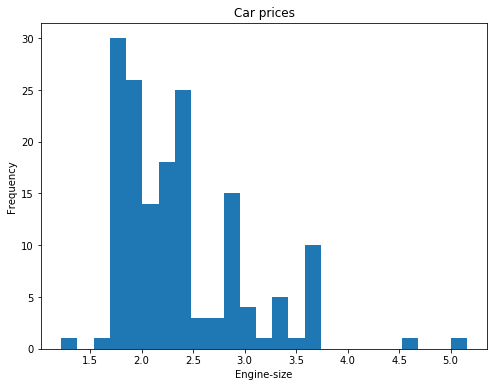

In [297]:
# Log transform
X_engine_log = np.log(X_engine)
# Histogram
plt.figure(figsize = (8,6))
plt.hist(X_engine_log, bins = 25)
plt.xlabel('Engine-size')
plt.ylabel('Frequency')
plt.title('Car prices')
plt.show()

### ========== Question 2.8 --- [3 marks] ==========
Now re-build a Linear Regression model on the transformed dataset and report the R^2, RMSE, MAE and CC metrics.

In [298]:
# Initialise a new Linear Regression model
MLR_transformed = LinearRegression(normalize = True)
# Use the 2D array for X as well as y vector from previous questions
X_engine_log_2D = np.reshape(X_engine_log, (-1,1))
mlr_transf_cross_pred = cross_val_predict(MLR_transformed, X_engine_log_2D, y, cv = k_fold.split(auto_numeric))
print("Prediction's dimensionality: {}, y vector's dimensionality: {}".format(mlr_transf_cross_pred.shape, y.shape))

# Show metrics
show_metrics(mlr_transf_cross_pred, y)

Prediction's dimensionality: (159,), y vector's dimensionality: (159,)
Correlation Coefficient:  0.822094616628
Coefficient of Determination:  0.675764118495
Root Mean Squared Error:  [ 3828.57108319]
Mean Absolute Error:  2487.15054381


### ========== Question 2.9 --- [3 marks] ==========
How has the performance of your model changed? Explain your answer in 1-2 sentences.

We can see a very high CC and a really good R^2 score. The RMSE is similar but the MAE is lower, which indicates better performance.

### ========== Question 2.10 --- [2 marks] ==========
So far we have performed regression with numeric attributes. We will now attempt to integrate nominal (categorical) attributes into our regression model. 
Load the dataset `train_auto_full.csv` into a pandas DataFrame called `auto_full`. Display the number of samples and attributes in the dataset. Also, display the first 20 instances of the dataset. *Hint: Execute the cell below to change the default for `max_columns` display option in pandas.*

In [299]:
pd.set_option('max_columns', 30)

In [300]:
# Load the datasets
data_path_auto_full = os.path.join(os.getcwd(), 'datasets', 'train_auto_full.csv')
auto_full = pd.read_csv(data_path_auto_full, delimiter = ',')
# Display info
print("Number of data points: {}".format(auto_full.shape[0]))
print("Number of attributes: {}".format(auto_full.shape[1]))
auto_full.head(20)

Number of data points: 159
Number of attributes: 27


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,symboling,mean-effective-pressure,torque,price
0,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,ohc,4,8.85,mpfi,3.19,3.40,10.00,102000.0,5500.0,24.0,30.0,2,40.52,57.68,13950.0
1,110.0,audi,gas,std,4,sedan,4wd,front,99.4,162.4,66.4,54.3,ohc,5,15.18,mpfi,3.19,3.40,8.00,115000.0,5500.0,18.0,22.0,2,47.39,59.59,17450.0
2,158.0,audi,gas,std,4,sedan,fwd,front,105.8,192.7,71.4,51.6,ohc,5,15.18,mpfi,3.94,2.80,8.50,70000.0,4400.0,28.0,30.0,1,0.85,3344.79,17710.0
3,106.0,audi,gas,turbo,4,sedan,fwd,front,86.6,158.7,67.7,55.9,ohc,5,13.74,mpfi,3.13,3.50,7.80,140000.0,5600.0,32.0,20.0,1,44.74,68.97,23875.0
4,192.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,4,8.67,mpfi,3.50,2.80,8.80,101000.0,5800.0,23.0,29.0,2,44.78,53.48,16430.0
5,194.0,bmw,gas,std,4,sedan,rwd,front,110.0,190.9,71.4,58.7,ohc,4,8.67,mpfi,3.78,3.90,22.50,101000.0,6000.0,47.0,53.0,0,1.80,1330.28,16925.0
6,188.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,6,26.58,mpfi,3.31,3.19,9.00,121000.0,4250.0,21.0,28.0,0,7.19,377.06,20970.0
7,150.0,bmw,gas,std,4,sedan,rwd,front,101.2,176.8,64.8,56.1,ohc,6,26.58,mpfi,3.03,3.19,8.00,134000.0,4400.0,28.0,37.0,0,57.37,48.20,21105.0
8,121.0,chevrolet,gas,std,2,hatchback,fwd,front,88.4,141.1,60.3,53.2,l,3,3.39,2bbl,3.03,3.03,9.50,48000.0,5300.0,47.0,53.0,2,59.33,25.08,5151.0
9,98.0,chevrolet,gas,std,2,hatchback,fwd,front,104.3,155.9,68.3,52.0,ohc,4,6.05,2bbl,3.31,3.47,7.80,70000.0,5000.0,34.0,34.0,1,51.55,36.35,6295.0


### ========== Question 2.11 --- [3 marks] ==========
This dataset contains a mixture of numeric and nominal attributes. Name the variables that you think are categorical. Why can we not use the nominal attributes in their current form for the purposes of regression? 

*Answer: *Categorical variables: make, fuel-type, aspiration, num-of-doors, body-style, drive-wheels, engine-location, engine-type, num-of-cylinders, fuel-system, symboling<br>
Linear regression assumes all independent variables are numerical, therefore we need to transform the categorical attributes.

### ========== Question 2.12 --- [5 marks] ==========
Now we want to convert the categorical variables by using [One-Hot-Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Familiarise yourself with the class. One limitation with this module is that it can deal only with categorical attributes in integer format (remember that in our example we have attributes in string format). 

Copy the `auto_full` dataframe into a new dataframe `auto_full_edit` and transform the categorical variables by using [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Then transform again the categorical variables by using One-Hot-Encoding. Make sure you don't transform the continuous variables. *Hint: make appropriate use of the `categorical_features` parameter in [`OneHotEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder).*

Store the transformed attributes into a numpy array `X_enc` and display its dimensionality.  


In [301]:
# Copy to a new dataframe
auto_full_edit = auto_full.copy(deep = True)

# Choose the categorical variables
categorical_variables = ['make','fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'symboling']
numerical_variables = list(set(auto_full_edit.columns.values) - set(categorical_variables))

# Use LabelEncoder to transform only the categorical variables (procedure from Lab 2 solutions)
le_dict = dict()
for column in auto_full_edit.drop(numerical_variables, axis = 1):
    le = LabelEncoder().fit(auto_full_edit[column])
    auto_full_edit[column] = le.transform(auto_full_edit[column])

# auto_full_edit.head(10)
auto_full_edit_noPrice = auto_full_edit.drop(['price'], axis = 1)
# Specify the indices of the categorical variable columns
categorical_indices = [1,2,3,4,5,6,7,12,13,15,23]
# Initialise the encoder and fit the dataset
OHE = OneHotEncoder(categorical_features = categorical_indices)
# OHE.fit(auto_full_edit_noPrice)
X_enc = OHE.fit_transform(auto_full_edit_noPrice) # Array doesn't perform well
print('Dimensionality of X_enc: {}'.format(X_enc.shape))

Dimensionality of X_enc: (159, 70)


### ========== Question 2.13 --- [2 marks] ==========
By using the transformed data train a multivariate linear regression model and by using 5-fold cross-validation report the R^2, RMSE, MAE and CC metrics.

In [302]:
y_tr = auto_full_edit['price']

# Initialise a new Linear Regression model
MLR_transformed_num = LinearRegression(normalize = True)
# Use the 2D array for X as well as y vector from previous questions
k_fold_tr = KFold(n_splits = 5, shuffle = True, random_state = 0)
mlr_transf_cross_pred_2 = cross_val_predict(MLR_transformed_num, X_enc, y_tr, cv = k_fold_tr.split(tr_data))
print("Prediction's dimensionality: {}, y vector's dimensionality: {}".format(mlr_transf_cross_pred_2.shape, y.shape))

# Show metrics
show_metrics(mlr_transf_cross_pred_2, y_tr)

Prediction's dimensionality: (159,), y vector's dimensionality: (159,)
Correlation Coefficient:  0.931517349598
Coefficient of Determination:  0.86383451765
Root Mean Squared Error:  [ 2481.07385412]
Mean Absolute Error:  1706.44341397


### ========== Question 2.14 --- [4 marks] ==========
How does this more complex model perform with respect to your best performing model from either question 2.3 or 2.8? List one advantage and one disadvantage of using the more complex model.

*Answer: *We can see that the CC and R^2 score are above 0.86, and nearer to 1 the better the model's predictions. The MAE is low at 1706, and RMSE at 2481. Therefore, this more complex model performs better, being more accurate and having smaller residuals.

### ========== Question 2.15 --- [4 marks] ==========
Finally, experiment with tree-based regressors (e.g. [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) and report 5-fold cross-validation scores for R^2, RMSE, MAE and CC. Has your performance improved? Explain your answer in 1-2 sentences.

In [303]:
# Original data
# 5-Fold
k_fold_trees = KFold(n_splits = 5, shuffle = True, random_state = 0)
# Use the RandomForestRegressor and fit the data
regr_o = RandomForestRegressor(max_depth=2, random_state=0)
# Predict and show metrics
trees_pred_o = cross_val_predict(regr, auto_full_edit_noPrice, y_tr, cv = k_fold_trees.split(X_enc))
print('Original:')
show_metrics(trees_pred_o, y_tr)

# Transformed data
# Use the RandomForestRegressor and fit the data
regr = RandomForestRegressor(max_depth=2, random_state=0)
# Predict and show metrics
trees_pred = cross_val_predict(regr, X_enc, y_tr, cv = k_fold_trees.split(X_enc))
print('Transformed:')
show_metrics(trees_pred, y_tr)

Original:
Correlation Coefficient:  0.888974384371
Coefficient of Determination:  0.789799591124
Root Mean Squared Error:  [ 3082.64103956]
Mean Absolute Error:  2213.73942543
Transformed:
Correlation Coefficient:  0.894578237957
Coefficient of Determination:  0.798827439375
Root Mean Squared Error:  [ 3015.71676006]
Mean Absolute Error:  2119.68226113


*Answer: *As we can see from the metrics, the tree-based regressor does not perform as well as the multivariate linear regressor with the transformed data, but performs much better than the linear regressor on the original data. The tree regressors are not affected by categorical/numerical attributes and will produce almost the same results. The linear regressors however, need to handle the categorical data in the way we implemented.